# 01b - Open Images Dataset

In this notebook we will explore Open Images dataset. [Open Images](https://storage.googleapis.com/openimages/web/index.html) is a dataset of ~9M images annotated with image-level labels, object bounding boxes, object segmentation masks, visual relationships, and localized narratives. It contains a total of 16M bounding boxes for 600 object classes on 1.9M images, making it the largest existing dataset with object location annotations.

In [1]:
# Create a folder for open-images-v5
!mkdir -p open-images-v5
%cd open-images-v5

/mnt/data/object_detection/open-images-v5


In [2]:
from pycocotools.coco import COCO
from tqdm import tqdm_notebook
import urllib.request
import os
import cv2
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20.0, 10.0)

## 1. Download

Download annotation files:

In [ ]:
# Training bounding boxes (1.11G)
!wget https://storage.googleapis.com/openimages/2018_04/train/train-annotations-bbox.csv

# Validating bounding boxes (23.94M)
!wget https://storage.googleapis.com/openimages/v5/validation-annotations-bbox.csv
    
# Testing bounding boxes (73.89M)
!wget https://storage.googleapis.com/openimages/v5/test-annotations-bbox.csv

# Class names of images (11.73K)
!wget https://storage.googleapis.com/openimages/v5/class-descriptions-boxable.csv

Obtain `downloadOI.py` from [learnopencv's tutorial](https://www.learnopencv.com/fast-image-downloader-for-open-images-v4/) to download specific classes from Open Image v5.

In [ ]:
# Download for Camera and Tripod images
!python3 downloadOI.py --classes 'Camera,Tripod' --mode train

## 2. Explore

### Label Description

We use `class-descriptions-boxable.csv` to get English name of each class.

In [3]:
labels = pd.read_csv("class-descriptions-boxable.csv", header=None, names=['LabelName', 'Label'])

In [4]:
# There are 601 classes
len(labels)

601

In [5]:
target_labels = ['Camera', 'Tripod']
subset_labels = labels[labels['Label'].isin(target_labels)]
subset_labels 

,LabelName,Label
370,/m/073bxn,Tripod
498,/m/0dv5r,Camera


### Label Hierarchy

View the set of boxable classes as a hierarchy [here](https://storage.googleapis.com/openimages/2018_04/bbox_labels_600_hierarchy_visualizer/circle.html).

In [ ]:
!wget https://storage.googleapis.com/openimages/2018_04/bbox_labels_600_hierarchy.json

In [6]:
import ast

with open("bbox_labels_600_hierarchy.json") as f:
    class_hier = f.read()

# Replace class code with class name
for row in range(len(labels)):
    row = labels.iloc[row, :]
    class_hier = class_hier.replace(row[0], row[1])

class_hier = ast.literal_eval(class_hier)

In [7]:
# Display a portion of all classes
class_hier['Subcategory'][:5]

[{'LabelName': 'Coin'},
 {'LabelName': 'Flag'},
 {'LabelName': 'Light bulb'},
 {'LabelName': 'Toy',
  'Subcategory': [{'LabelName': 'Doll'},
   {'LabelName': 'Balloon'},
   {'LabelName': 'Dice'},
   {'LabelName': 'Flying disc'},
   {'LabelName': 'Kite'},
   {'LabelName': 'Teddy bear'}]},
 {'LabelName': 'Home appliance',
  'Subcategory': [{'LabelName': 'Washing machine'},
   {'LabelName': 'Toaster'},
   {'LabelName': 'Oven'},
   {'LabelName': 'Blender'},
   {'LabelName': 'Gas stove'},
   {'LabelName': 'Mechanical fan'},
   {'LabelName': 'Heater'},
   {'LabelName': 'Kettle'},
   {'LabelName': 'Hair dryer'},
   {'LabelName': 'Refrigerator'},
   {'LabelName': 'Wood-burning stove'},
   {'LabelName': 'Humidifier'},
   {'LabelName': 'Mixer'},
   {'LabelName': 'Coffeemaker'},
   {'LabelName': 'Microwave oven'},
   {'LabelName': 'Dishwasher'},
   {'LabelName': 'Sewing machine'},
   {'LabelName': 'Hand dryer'},
   {'LabelName': 'Ceiling fan'}]}]

### Train Data

The annotations are saved in a `csv` file, where each line represents a box. We can inner join the annotation file with `subset_labels` to extract annotations of our target classes only.

In [8]:
train_data = pd.read_csv("train-annotations-bbox.csv")
train_data = train_data.merge(subset_labels, on='LabelName')
train_data.head(3)

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside,Label
0,000091f4a275d0fb,xclick,/m/0dv5r,1,0.472857,0.598571,0.217204,0.443011,0,0,0,0,0,Camera
1,0002a1a755d730ca,xclick,/m/0dv5r,1,0.404687,0.715625,0.172917,0.414583,1,0,0,0,0,Camera
2,00034cd6adabef6a,xclick,/m/0dv5r,1,0.755000,0.998125,0.834167,0.999167,1,1,0,0,0,Camera


There are 6091 unique images containing either Camera or Tripod.

In [9]:
train_data['ImageID'].nunique()

6091

Number of objects:

In [10]:
train_data['Label'].value_counts()

Camera    6404
Tripod    1446
Name: Label, dtype: int64

5949 images contain only one type of objects, and 142 images contain both Camera and Tripod.

In [11]:
train_data.groupby('ImageID')['Label'].nunique().value_counts()

1    5949
2     142
Name: Label, dtype: int64

**Visualize bounding boxes**

In [12]:
# Get images containing 2 classes
label_counts = train_data.groupby('ImageID')['Label'].nunique()
img_with_two_labels = label_counts.index[label_counts == 2].tolist()

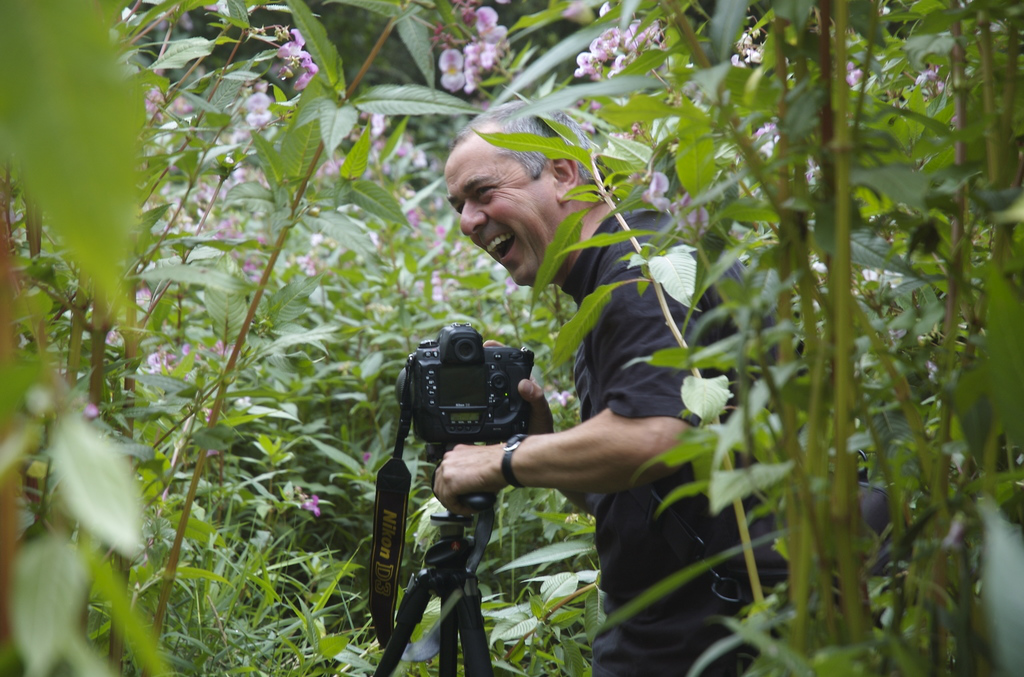

In [13]:
img_id = np.random.choice(img_with_two_labels)
im = Image.open(f"train/{img_id}.jpg")
im

The bounding boxes are normalized with values between 0 and 1. We need to denormalize these boxes first.

In [14]:
# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

def denormalize_bboxes(bboxes, height, width):
    bboxes[:, [0, 2]] = bboxes[:, [0, 2]] * width
    bboxes[:, [1, 3]] = bboxes[:, [1, 3]] * height
    return bboxes

def plot_boxes(pil_img, boxes, classes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    for box, cl, c in zip(boxes.tolist(), classes, COLORS * 100):
        xmin, ymin, xmax, ymax = box
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        ax.text(xmin, ymin, cl, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show();

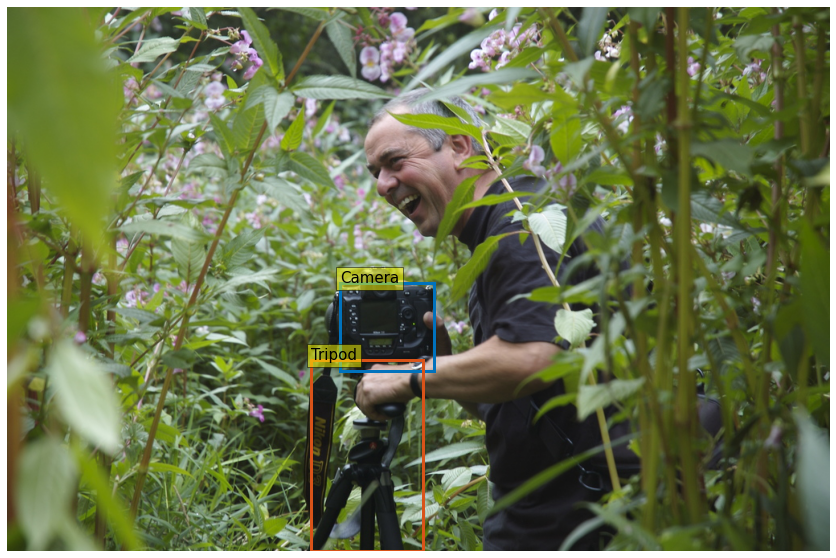

In [15]:
# Denormalize bboxes
height, width = np.array(im).shape[:2]
bboxes = train_data[train_data['ImageID'] == img_id][['XMin', 'YMin', 'XMax', 'YMax']].values
bboxes = denormalize_bboxes(bboxes, height, width)

# Get class label
classes = train_data[train_data['ImageID'] == img_id]['Label'].values

# Plot
plot_boxes(im, bboxes, classes)

### Validation Data

In [16]:
validation_data = pd.read_csv("validation-annotations-bbox.csv")
validation_data = validation_data.merge(subset_labels, on='LabelName')

Validation set has only 193 annotations and 166 images.

In [17]:
len(validation_data)

193

In [18]:
validation_data['ImageID'].nunique()

166

Object counts:

In [19]:
validation_data['Label'].value_counts()

Camera    153
Tripod     40
Name: Label, dtype: int64

In the next notebook, we will learn how to transform Open Image annotation format for Detectron2.